In [122]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import statsmodels.formula.api as smf
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model
from sklearn.ensemble import GradientBoostingClassifier
## for explainer
from lime import lime_tabular
from sklearn.utils import shuffle
from pandas.core.computation.check import NUMEXPR_INSTALLED

## Bezogen auf einzelne Events

In [123]:
#get our data
df_data = pd.read_pickle('CleanedDataWithIds.pkl')

In [124]:
df_data.shape

(8882, 13)

In [125]:
df_data['timeStamp'] = df_data['timeStamp'].astype(float)
# df_data['clientX'] = df_data['clientX'].astype(float)
# df_data['clientY'] = df_data['clientY'].astype(float)
df_data['height'] = df_data['height'].astype(float)
df_data['width'] = df_data['width'].astype(float)
df_data['real_date'] = df_data['date'].astype('datetime64[ns]')

In [126]:
df_data = df_data.drop(['sitename', 'date', 'elementId', 'clientX', 'clientY'], axis=1)

In [127]:
print(df_data)

       timeStamp       type  siteName  session  height   width  browser  key  \
339        824.3  mouseover         0      898   944.0  1920.0      NaN  NaN   
340        858.3   mouseout         0      898   944.0  1920.0      NaN  NaN   
341       2005.3  mouseover         0      898   944.0  1920.0      NaN  NaN   
342       2296.5      focus         0      898   944.0  1920.0   Chrome  NaN   
343       2875.3  mouseover         0      898   944.0  1920.0      NaN  NaN   
...          ...        ...       ...      ...     ...     ...      ...  ...   
36003    44062.0  mouseover         1      874   868.0  1544.0      NaN  NaN   
36004    44112.0   mouseout         1      874   868.0  1544.0      NaN  NaN   
36005    44524.0       blur         1      874   868.0  1544.0  Firefox  NaN   
36007    47923.0      click         1      874   868.0  1544.0  Firefox  NaN   
36008    48454.0      click         1      874   868.0  1544.0  Firefox  NaN   

                    real_date  
339   2

In [128]:
#one hot encoding 
## create dummy

types = pd.get_dummies(df_data["type"], 
                       prefix="type")
df_data= pd.concat([df_data, types], axis=1)
## drop the original categorical column
df_data = df_data.drop("type", axis=1)

df_data.head()

,timeStamp,siteName,session,height,width,browser,key,real_date,type_blur,type_click,type_focus,type_keydown,type_mouseout,type_mouseover
339,824.3,0,898,944.0,1920.0,NaN,NaN,2022-10-17 13:35:24.171,0,0,0,0,0,1
340,858.3,0,898,944.0,1920.0,NaN,NaN,2022-10-17 13:35:24.205,0,0,0,0,1,0
341,2005.3,0,898,944.0,1920.0,NaN,NaN,2022-10-17 13:35:25.361,0,0,0,0,0,1
342,2296.5,0,898,944.0,1920.0,Chrome,NaN,2022-10-17 13:35:25.652,0,0,1,0,0,0
343,2875.3,0,898,944.0,1920.0,NaN,NaN,2022-10-17 13:35:26.230,0,0,0,0,0,1


In [129]:
df_data[df_data.columns[1:]].corr()['siteName'][:].sort_values(ascending=False).to_frame()


<ipython-input-129-d7f09a78c057>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_data[df_data.columns[1:]].corr()['siteName'][:].sort_values(ascending=False).to_frame()


,siteName
siteName,1.000000
type_click,0.184769
type_mouseover,0.161658
type_mouseout,0.160528
height,0.159036
width,0.137745
type_blur,0.047220
type_focus,0.042526
session,-0.016148
type_keydown,-0.609864


<ipython-input-130-857b9925b8f3>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_data.corr()


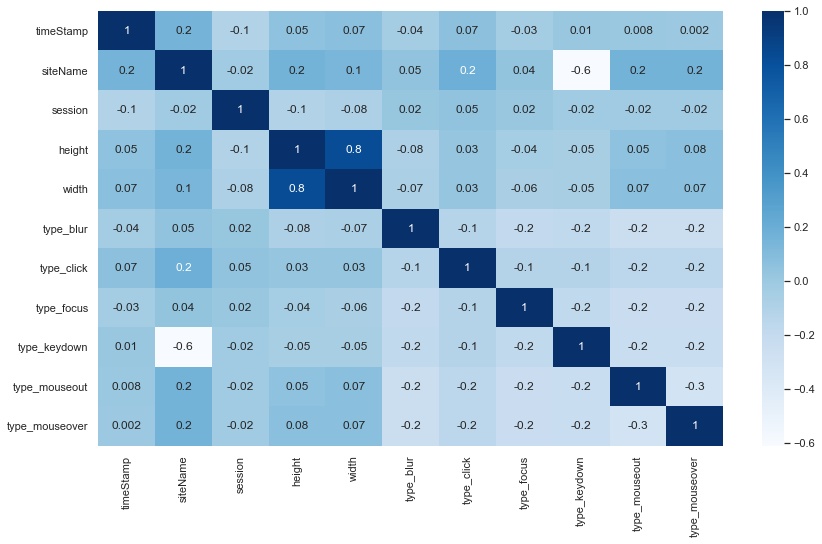

In [130]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df_data.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

<ipython-input-131-3797e0e63f06>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_data.corr()


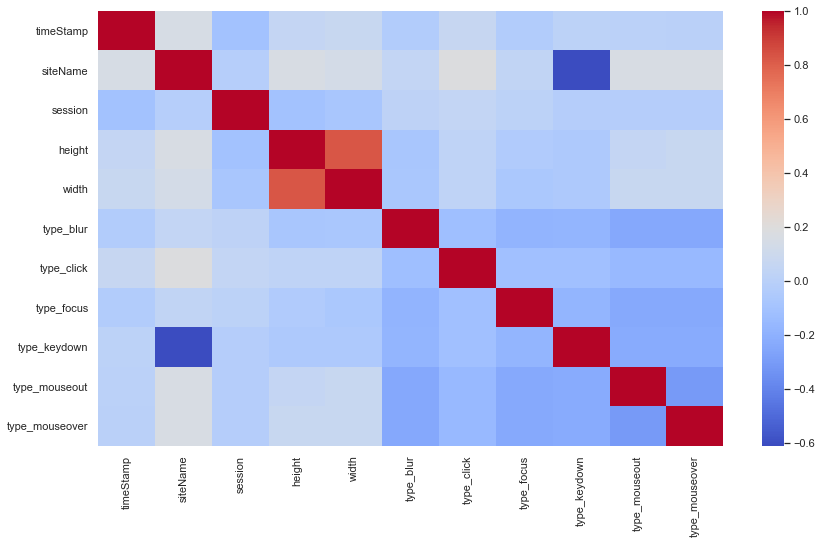

In [131]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df_data.corr()
heatmap = sns.heatmap(corr, cmap="coolwarm")

## Bezogen auf jede Session Count

In [132]:
#get our data
df_session = pd.read_pickle('SortedBySessions.pkl')

In [133]:
df_session.shape

(129, 11)

In [134]:
df_session.head()

,session,count_mouseover,count_mouseout,count_click,count_blur,count_focus,count_keydown,duration,height,width,siteName
0,512,7,7,0,7,7,4,18.157,664,390,0
1,518,70,70,25,31,32,13,459.177,667,1440,1
2,519,6,6,0,7,7,0,18.090,775,412,0
3,520,39,39,3,14,13,29,232.459,1217,1440,1
4,538,8,8,4,17,15,20,213.904,664,390,1


In [135]:
df_session[df_session.columns[1:]].corr()['siteName'][:].sort_values(ascending=False).to_frame()


<ipython-input-135-766e9363d5fb>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_session[df_session.columns[1:]].corr()['siteName'][:].sort_values(ascending=False).to_frame()


,siteName
siteName,1.000000
duration,0.485823
count_click,0.427431
count_blur,0.381698
count_keydown,0.379730
count_focus,0.368224
count_mouseover,0.359331
count_mouseout,0.356476


<ipython-input-136-7cd0afc3e693>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_session = df_session.corr()


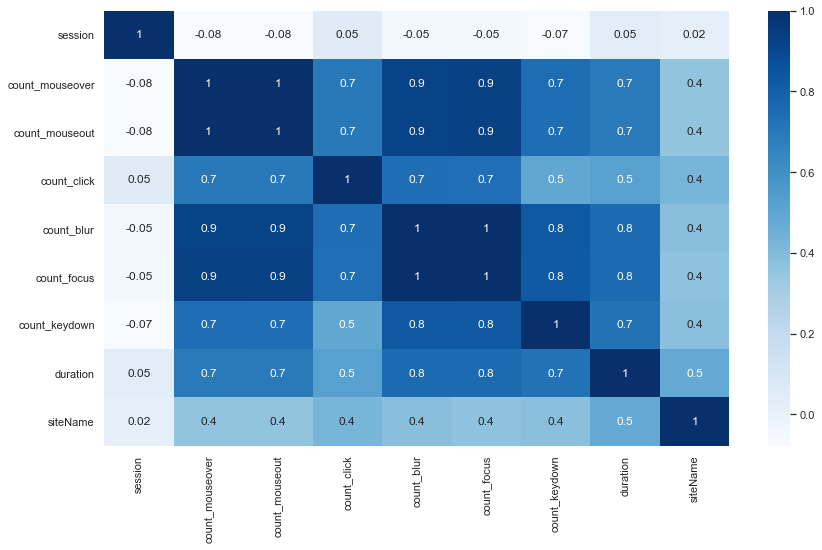

In [136]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr_session = df_session.corr()
heatmap = sns.heatmap(corr_session, annot=True, cmap="Blues", fmt='.1g')

<ipython-input-137-69c993510c7b>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_session = df_session.corr()


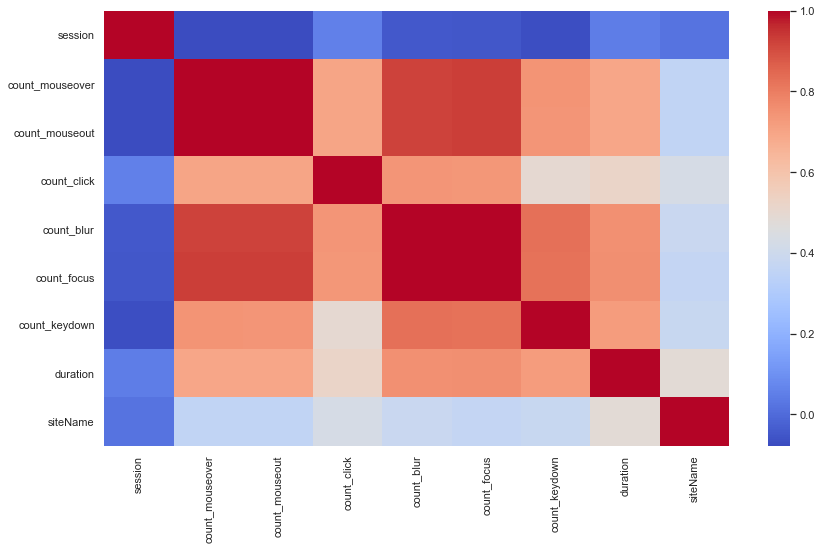

In [137]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr_session = df_session.corr()
heatmap = sns.heatmap(corr_session, cmap="coolwarm")

<ipython-input-138-43b53e66ede3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_session = df_session.corr()
<ipython-input-138-43b53e66ede3>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(df_session.corr())


<AxesSubplot: >

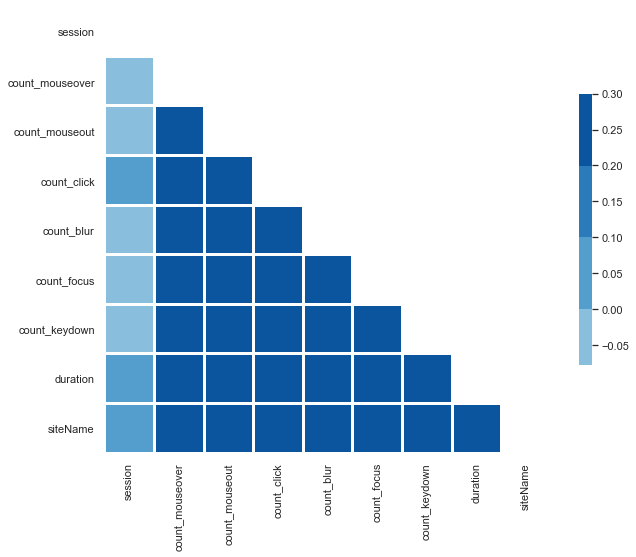

In [138]:
sns.set_theme(style="white")
corr_session = df_session.corr()
mask = np.triu(df_session.corr())
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.color_palette("Blues")

sns.heatmap(corr_session, 
            mask=mask, 
            cmap=cmap, 
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=3, 
            cbar_kws={"shrink": .5}
           )

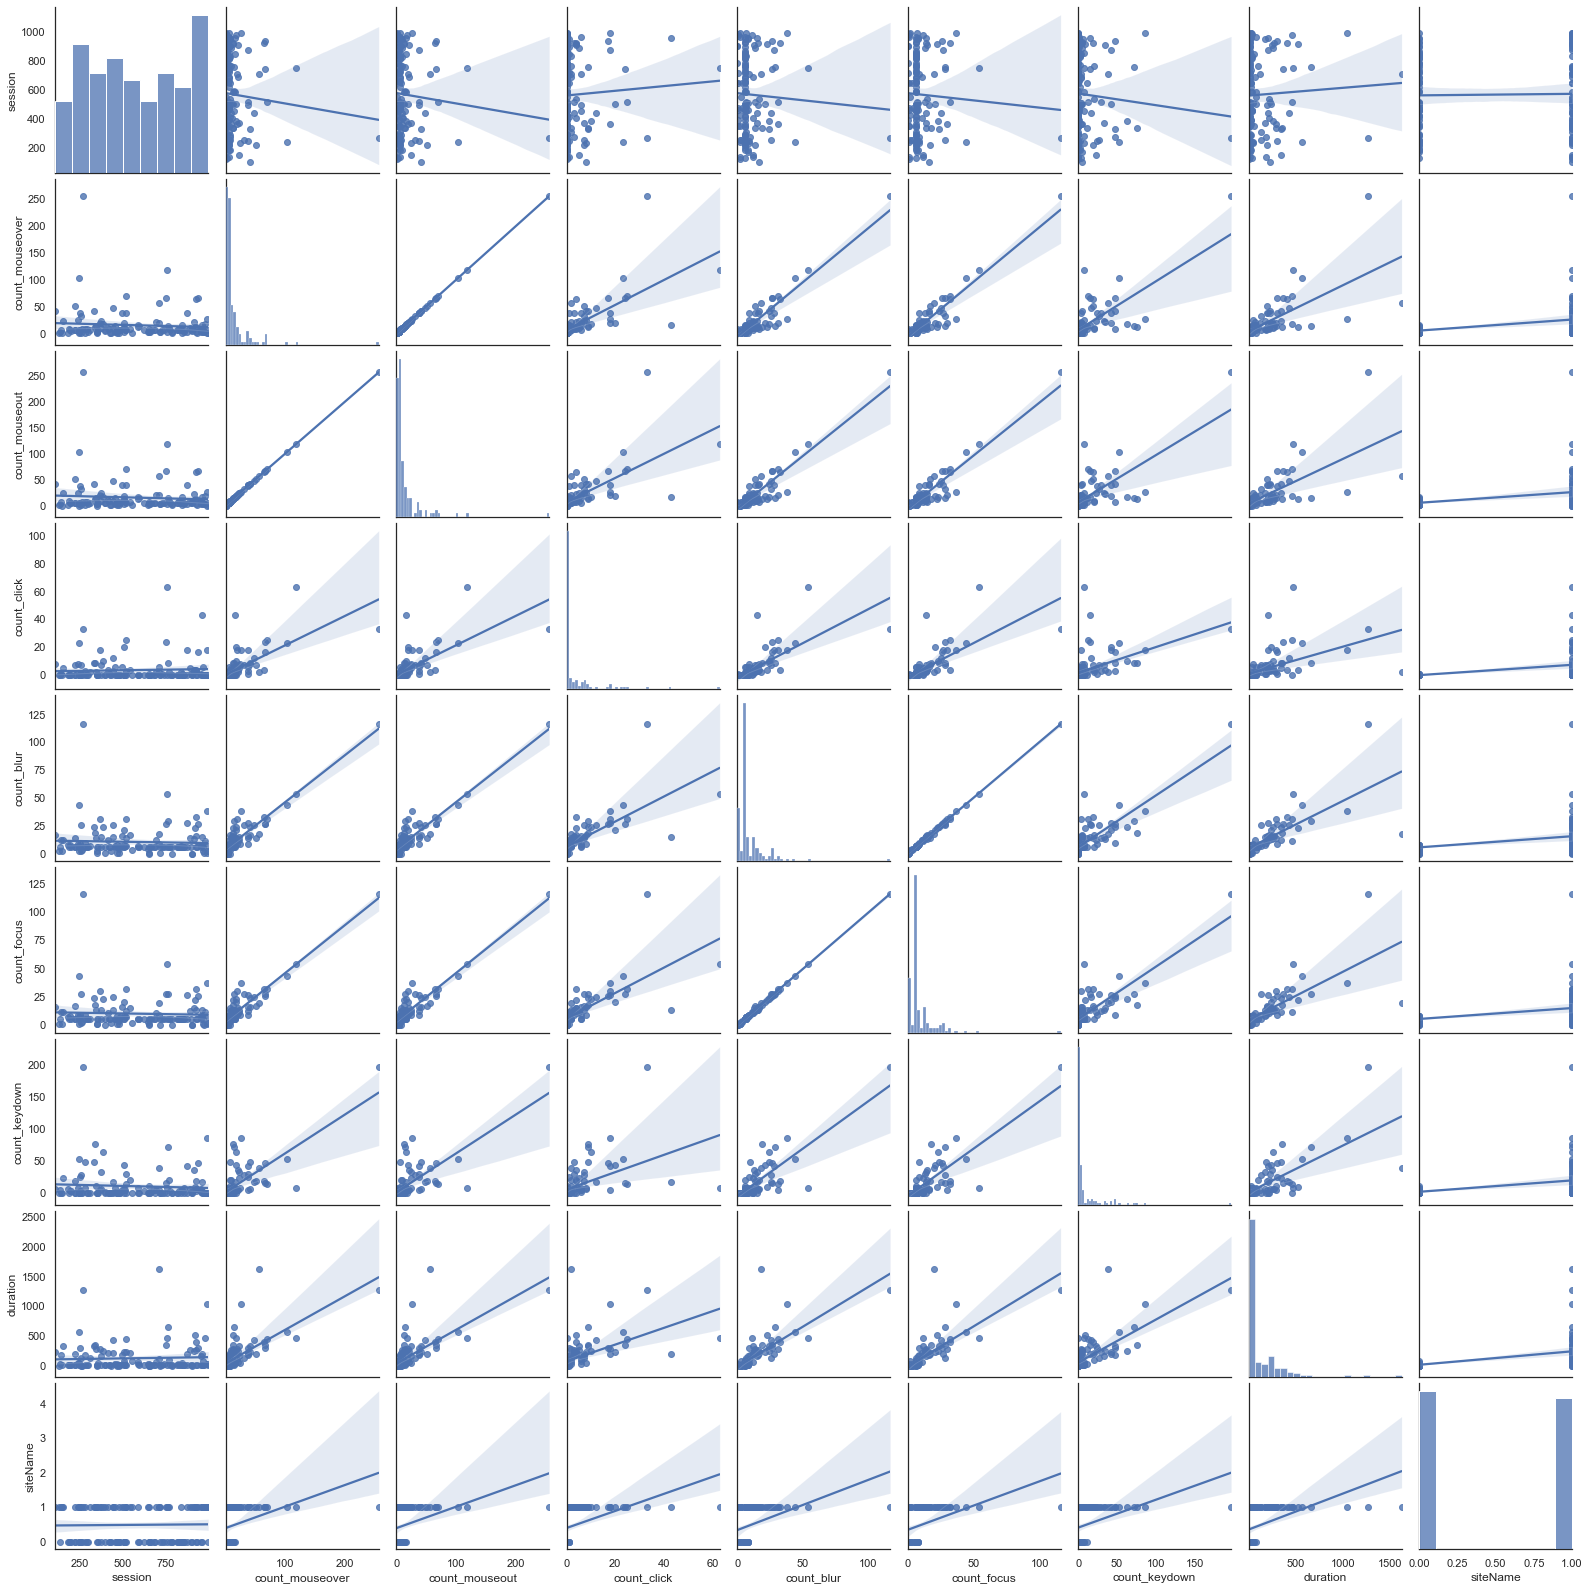

In [139]:
sns.pairplot(df_session, kind="reg")
